In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io,transform
from torchvision import transforms,utils
import numpy as np
import torch

#Edit the input data to be one large matrix, and then append a y for input#
#####Prepare the Training Data from the Numpy Arrays#####
#load the feather data#
feather_file=np.load('20191005_FEATHER_Training_Points1.npy')
#load the non-feather points#
non_feather_file=np.load('20191005_NONFEATHER_Training_Points1.npy')
#now go in and get the shapes of them#
total_training_points=np.shape(feather_file)[0]+np.shape(non_feather_file)[0]
training_data=np.zeros([total_training_points,3,50])
training_data[0:np.shape(feather_file)[0],:,:]=feather_file
training_data[np.shape(feather_file)[0]:total_training_points,:,:]=non_feather_file
#create the labels vector#
pos_labs=np.ones([np.shape(feather_file)[0],1])
neg_labs=np.zeros([np.shape(non_feather_file)[0],1])
#concatenate them#
label_vector=np.concatenate((np.squeeze(pos_labs),np.squeeze(neg_labs)),axis=0)


#####Prepare the Testing Data from the Numpy Arrays#####
#load the feather data#
test_feather_file=np.load('20191005_FEATHER_Training_Points1.npy')
#load the non-feather points#
test_non_feather_file=np.load('20191005_NONFEATHER_Training_Points1.npy')
#now go in and get the shapes of them#
total_testing_points=np.shape(test_feather_file)[0]+np.shape(test_non_feather_file)[0]
testing_data=np.zeros([total_testing_points,3,50])
testing_data[0:np.shape(test_feather_file)[0],:,:]=test_feather_file
testing_data[np.shape(test_feather_file)[0]:total_testing_points,:,:]=test_non_feather_file
#create the labels vector#
pos_labs=np.ones([np.shape(test_feather_file)[0],1])
neg_labs=np.zeros([np.shape(test_non_feather_file)[0],1])
#concatenate them#
test_label_vector=np.concatenate((np.squeeze(pos_labs),np.squeeze(neg_labs)),axis=0)


class FeatherPointClass(Dataset):
    def __init__(self, training_data,labels, datatype, transform = transforms.Compose([transforms.ToTensor()])):
        self.datatype = datatype
        self.data=training_data

        if self.datatype == 'train':
            self.labels=labels
        self.transform = transform


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            return np.reshape(training_data[idx,:,:],[training_data[0,:,:].size]),label_vector[idx]

        if self.datatype == 'test':
            return np.reshape(training_data[idx,:,:],[training_data[0,:,:].size]),test_label_vector[idx]
  

            


In [2]:
#now define the network#
class FeatherNet(torch.nn.Module):
    def __init__(self):
        super(FeatherNet,self).__init__()
        self.linear_layer1=torch.nn.Linear(in_features=150,out_features=128)
        self.linear_layer2=torch.nn.Linear(in_features=128,out_features=64)
        self.linear_layer3=torch.nn.Linear(in_features=64,out_features=32)
        self.linear_layer4=torch.nn.Linear(in_features=32,out_features=16)
        self.linear_layer5=torch.nn.Linear(in_features=16,out_features=1)
        self.relu=torch.nn.LeakyReLU()
#         self.linear_layer4=torch.nn.Linear(in_features=5,out_features=1)
#         self.linear_layer5=torch.nn.Linear(in_features=30,out_features=1)


    def forward(self,x):
        x=self.linear_layer1(x)
        x=self.relu(x)
        x=self.linear_layer2(x)
        x=self.relu(x)
        x=self.linear_layer3(x)
        x=self.relu(x)
        x=self.linear_layer4(x)
        x=self.relu(x)
        x=self.linear_layer5(x)
        return x
    

feather_model=FeatherNet()
feather_model=feather_model.float()

feather_train_class=FeatherPointClass(training_data=training_data,datatype='train',labels=label_vector)
feather_test_class=FeatherPointClass(training_data=testing_data,datatype='test',labels=test_label_vector)


train_loader = torch.utils.data.DataLoader(feather_train_class, batch_size=500, sampler=None,shuffle=True, num_workers=1)
test_loader=torch.utils.data.DataLoader(feather_test_class,batch_size=500,num_workers=1,shuffle=True)



criterion=torch.nn.BCEWithLogitsLoss()

optimizer=torch.optim.Adam(feather_model.parameters(),lr=.001)#lr=0.00001 batch_size=300
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1800], gamma=0.1)

loss=0
loss_record=[]
correct_record=[]
pos_correct=[]
neg_correct=[]

for epoch in range(2):#600 
    feather_model.train()
    losses=[]


    for batch_i,(point_vector,label) in enumerate(train_loader):
        
        optimizer.zero_grad()
        z=point_vector.float()
        out=feather_model(torch.squeeze(z))
        loss=criterion(torch.squeeze(out),label.float())
        loss.backward()
        optimizer.step()
    loss_record.append(loss)
    
#     now we want to evaluate the model#
    with torch.no_grad():
        feather_model.eval()
        pos_correct_tmp=[]
        neg_correct_tmp=[]
        correct_record_tmp=[]
        for batch_i,(point_vector,label) in enumerate(test_loader):
            z=point_vector.float()
            out=feather_model(torch.squeeze(z))
            cat=torch.nn.Sigmoid()
            cat1=cat(out)
            cat1=cat1.data.numpy()
            label1=label.data.numpy()
            cat2=np.round(cat1-.65+.5)#the threshold is .75
            test_add=np.squeeze(cat2)+label1
            pos_pos=np.count_nonzero(test_add==2)
            neg_neg=np.count_nonzero(test_add==0)
            true_pos=np.count_nonzero(label1==1)
            true_neg=np.count_nonzero(label1==0)
            total_correct=neg_neg+pos_pos
            correct_record_tmp.append(total_correct/len(cat2)*100)
            pos_correct_tmp.append(pos_pos/true_pos*100)
            neg_correct_tmp.append(neg_neg/true_neg*100)
    pos_correct.append(np.mean(pos_correct_tmp))
    neg_correct.append(np.mean(neg_correct_tmp))

            

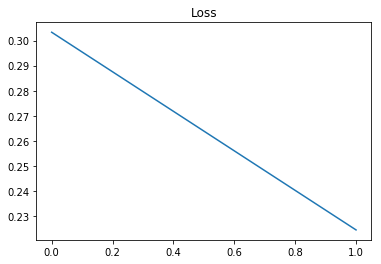

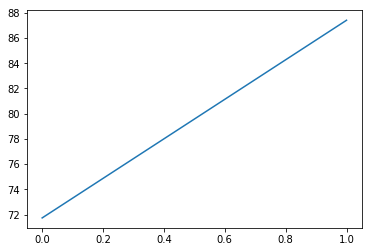

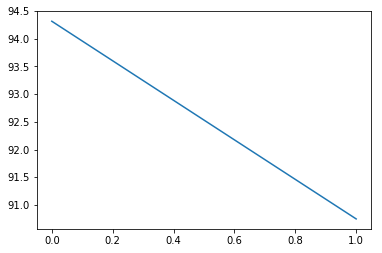

In [4]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.title('Loss')
plt.show()

plt.plot(pos_correct)
plt.show()

plt.plot(neg_correct)
plt.show()


In [12]:
import numpy as np
from stl import mesh
surface_mesh = mesh.Mesh.from_file('/Users/tylerthompson/Desktop/Research/Feather_Project/highdef_feather_cow.stl')
[faces,v_points]=np.shape(surface_mesh)
#go through there and get the points#
vertex_coords=np.zeros([3*faces,3])
for kk in range(0,3*faces,3):
    #form the vector#
    point_list=surface_mesh[np.int(kk/3),:]
    point_list=np.reshape(point_list,[3,3])
    vertex_coords[kk:kk+3,:]=point_list
print("Vertices Acquired")
    #now remove duplicates#
temp_vertices=set(tuple(x) for x in vertex_coords)
print('Set Made')
sparce_verts=np.array([list(x) for x in temp_vertices])
print('Sparse Vertices Acquired')
xs_ref=sparce_verts[0::4,0]
ys_ref=sparce_verts[0::4,1]
zs_ref=sparce_verts[0::4,2]
del temp_vertices
del sparce_verts
import numpy
from mayavi import mlab
from mayavi.mlab import *


Vertices Acquired
Set Made
Sparse Vertices Acquired


In [13]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io,transform
from torchvision import transforms,utils
import numpy as np
import torch

class FeatherNet(torch.nn.Module):
    def __init__(self):
        super(FeatherNet,self).__init__()
        self.linear_layer1=torch.nn.Linear(in_features=150,out_features=128)
        self.linear_layer2=torch.nn.Linear(in_features=128,out_features=64)
        self.linear_layer3=torch.nn.Linear(in_features=64,out_features=32)
        self.linear_layer4=torch.nn.Linear(in_features=32,out_features=16)
        self.linear_layer5=torch.nn.Linear(in_features=16,out_features=1)
        self.relu=torch.nn.LeakyReLU()
#         self.linear_layer4=torch.nn.Linear(in_features=5,out_features=1)
#         self.linear_layer5=torch.nn.Linear(in_features=30,out_features=1)


    def forward(self,x):
        x=self.linear_layer1(x)
        x=self.relu(x)
        x=self.linear_layer2(x)
        x=self.relu(x)
        x=self.linear_layer3(x)
        x=self.relu(x)
        x=self.linear_layer4(x)
        x=self.relu(x)
        x=self.linear_layer5(x)
        return x
    
class FeatherPointClass(Dataset):
    def __init__(self, training_data,labels, datatype, transform = transforms.Compose([transforms.ToTensor()])):
        self.datatype = datatype
        self.data=training_data

        if self.datatype == 'train':
            self.labels=labels
        self.transform = transform


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            return np.reshape(training_data[idx,:,:],[training_data[0,:,:].size]),label_vector[idx]

        if self.datatype == 'test':
            return np.reshape(training_data[idx,:,:],[training_data[0,:,:].size]),test_label_vector[idx]
  




training_data=np.load('20191005_horus_surface_eval.npy')
num_training_pts=np.shape(training_data)[0]
label_vector=np.ones(np.shape(training_data)[0])
feather_train_class=FeatherPointClass(training_data=training_data,datatype='train',labels=label_vector)
train_loader = torch.utils.data.DataLoader(feather_train_class, batch_size=num_training_pts, sampler=None,shuffle=True, num_workers=1)
print(num_training_pts)






1145921


In [14]:
sig_layer=torch.nn.Sigmoid()
# feather_model=torch.load('feather_model_cowV1.pt')
for batch_i,(point_vector,label) in enumerate(train_loader):
    feather_model.eval()
    z=point_vector.float()
    out=feather_model(torch.squeeze(z))
    out=sig_layer(out)
# now convert the predictions to numpy#
predictions=out.data.numpy()
pos_predictions=np.squeeze(np.where(predictions>0.7))[0]
neg_predictions=np.squeeze(np.where(predictions<0.7))[0]


scrambled_data=point_vector.data.numpy()
scrambled_data=scrambled_data.reshape([len(pos_predictions)+len(neg_predictions),3,50])
xs=scrambled_data[:,0,1]
ys=scrambled_data[:,1,1]
zs=scrambled_data[:,2,1]


In [15]:
predicted_feather_xs=np.zeros([len(pos_predictions)])
predicted_feather_ys=np.zeros([len(pos_predictions)])
predicted_feather_zs=np.zeros([len(pos_predictions)])
predicted_non_feather_xs=np.zeros([len(neg_predictions)])
predicted_non_feather_ys=np.zeros([len(neg_predictions)])
predicted_non_feather_zs=np.zeros([len(neg_predictions)])
for jj in range(len(pos_predictions)):
    predicted_feather_xs[jj]=xs[pos_predictions[jj]]
    predicted_feather_ys[jj]=ys[pos_predictions[jj]]
    predicted_feather_zs[jj]=zs[pos_predictions[jj]]
for jj in range(len(neg_predictions)):
    predicted_non_feather_xs[jj]=xs[neg_predictions[jj]]
    predicted_non_feather_ys[jj]=ys[neg_predictions[jj]]
    predicted_non_feather_zs[jj]=zs[neg_predictions[jj]]

import numpy
from mayavi import mlab
from mayavi.mlab import *
points3d(predicted_feather_xs,predicted_feather_ys,predicted_feather_zs,scale_factor=0.2,color=(0,1,0))
points3d(predicted_non_feather_xs,predicted_non_feather_ys,predicted_non_feather_zs,color=(1,0,0),scale_factor=0.2)
# points3d(xs_ref,ys_ref,zs_ref,color=(0,0,1),scale_factor=0.002)
mlab.show()
    
    
    
    
    
    